In [1]:
%pip install pandas psycopg2-binary sqlalchemy matplotlib scikit-learn numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import psycopg2 as db
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os

In [3]:
db_type = 'postgresql'
host = 'database'
port = 5432
db_name = os.environ.get('POSTGRES_DB')
user = os.environ.get('POSTGRES_USER')
password = os.environ.get('POSTGRES_PASSWORD')

conn_uri = f"{db_type}://{user}:{password}@{host}:{port}/{db_name}"
alchemyEngine = create_engine(conn_uri)
db_conn = alchemyEngine.connect();

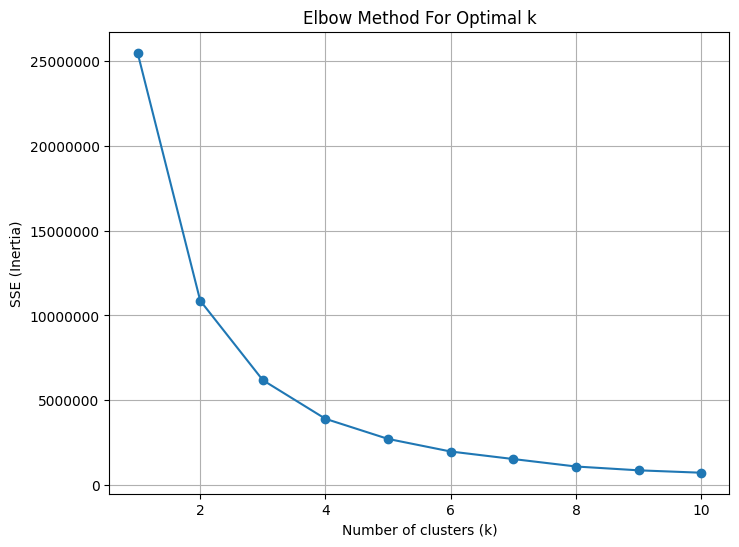

In [ ]:
""" Plot Number of customers per day """
db_conn = alchemyEngine.connect();
## Group user frequency
query = """
    SELECT COUNT(*) as frequency
    FROM customers
    WHERE event_type = 'purchase'
    GROUP BY user_id,
"""
df = pd.read_sql(query, db_conn)

# Step 2: Prepare for clustering
X = df[['frequency']]  # Use frequency as the feature

# Step 3: Compute SSE for a range of k values
sse = []
k_range = range(1, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    sse.append(km.inertia_)

# Step 4: Plot the Elbow
plt.figure(figsize=(8, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method For Optimal k')
plt.ticklabel_format(axis='y', style='plain')
plt.grid(True)
plt.show()
# df.describe()

In [8]:
df.describe()

,frequency,cluster
count,92651.000000,92651.000000
mean,11.269506,0.242415
std,16.584922,0.642810
min,1.000000,0.000000
25%,3.000000,0.000000
50%,6.000000,0.000000
75%,13.000000,0.000000
max,476.000000,2.000000


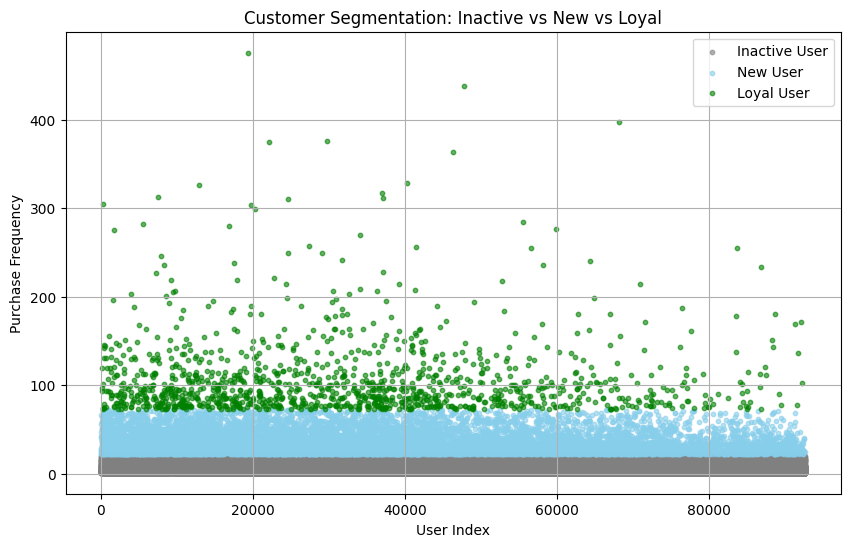

In [6]:
# Step 1: Run KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(df[['frequency']])

# Step 2: Sort clusters by average frequency (to assign meaningful labels)
cluster_order = df.groupby('cluster')['frequency'].mean().sort_values()
cluster_labels = {
    cluster_order.index[0]: 'Inactive User',
    cluster_order.index[1]: 'New User',
    cluster_order.index[2]: 'Loyal User'
}
df['segment'] = df['cluster'].map(cluster_labels)

# Step 3: Plot the labeled segments
plt.figure(figsize=(10, 6))
colors = {'Inactive User': 'gray', 'New User': 'skyblue', 'Loyal User': 'green'}

for label, color in colors.items():
    subset = df[df['segment'] == label]
    plt.scatter(subset.index, subset['frequency'], label=label, color=color, alpha=0.6, s=10)

plt.xlabel('User Index')
plt.ylabel('Purchase Frequency')
plt.title('Customer Segmentation: Inactive vs New vs Loyal')
plt.legend()
plt.grid(True)
plt.show()

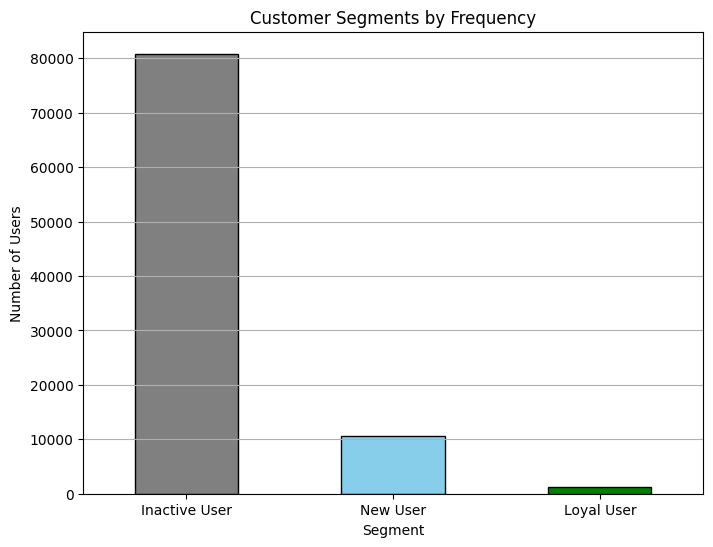

In [7]:
# Count users per segment
segment_counts = df['segment'].value_counts()

# Bar chart
plt.figure(figsize=(8, 6))
segment_counts.plot(kind='bar', color=['gray', 'skyblue', 'green'], edgecolor='black')

plt.title('Customer Segments by Frequency')
plt.xlabel('Segment')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()